# ID3连续值决策树（最大深度限定）

## 导入需要的包

In [1]:
import math
import numpy as np
import os

## 从文件中加载数据（traindata）

In [2]:
def loadData(fileName):
    dataArr = []; labelArr = []; nameArr = []
    fr = open(fileName)
    length = len(fr.readlines())
    fr.seek(0,0)    #最后一行为空行，光标从末尾读取一直为空，必须移动到开头重新读取
    lines = fr.readlines()
    for line in lines[1:length-1]:
        curline = line.strip().split()
        floatline = list(map(float,curline[0:-1]))
        intline = int(curline[-1])
        dataArr.append([num for num in floatline])
        labelArr.append(intline)
    
    for i in range(len(dataArr[0])):
        nameArr.append("属性"+str(i+1))
    dataArr = np.asarray(dataArr)
    labelArr = np.asarray(labelArr)
    return dataArr, labelArr, nameArr

## 信息熵的计算；信息增益的计算；获取数据集子集（data_left, data_right, label_left, label_right）

In [3]:
#计算信息熵的函数
def singleEntropy(labelArr):
    """计算一个输入序列的信息熵"""
    n = len(labelArr)
    dic ={}
    for label in labelArr:
        if label not in dic.keys():
            dic[label] = 0
        dic[label] += 1
    entropy = 0
    for key in dic:
        p = float(dic[key]) / n
        entropy += -p * np.log2(p)
    return entropy

def getSubData(dataArr,labelArr,feature,point):
    index_left = (dataArr[:, feature] <= point)
    index_right = (dataArr[:, feature] > point)

    data_left = dataArr[index_left]
    data_right = dataArr[index_right]

    label_left = labelArr[index_left]
    label_right = labelArr[index_right]
    return data_left, data_right, label_left, label_right


#信息增益
def infoGain(dataArr, labelArr, a):
    entropy = singleEntropy(labelArr)
    value = [fea[a] for fea in dataArr]
    value = list(set(value))
    value.sort()
    select_points = []
    n = len(value)

    for i in range(n - 1):
        val = (value[i] + value[i + 1]) / 2
        _,_,label_left,label_right = getSubData(dataArr,labelArr,a,val)
        ent_left = singleEntropy(label_left)
        ent_right = singleEntropy(label_right)

        exception = len(label_left) / len(labelArr) * ent_left + len(label_right) / len(labelArr) * ent_right
        result = entropy - exception
        select_points.append([val, result])
    select_points.sort(key=lambda x: x[1], reverse=True)
    # print(select_points)
    return select_points[0][0], select_points[0][1]
    
testdata,testlabel, nameArr = loadData("data/traindata.txt")
en = singleEntropy(testlabel)
print(en)
num1,en1 = infoGain(testdata,testlabel,3)
num2,en2 = infoGain(testdata,testlabel,2)
print(num1,en1)
print(num2,en2)


1.584962500721156
0.8 0.9182958340544894
2.45 0.9182958340544894


## 特征选取 + 多数投票

In [4]:
#特征选取
def bestfeature(dataArr, labels, nameArr):
    data = np.asarray(dataArr)
    labels = np.asarray(labels)
    
    featureNum = data.shape[1]
    bestFeature = -100; bestEntropy = -100; bestPoint = 0
    for i in range(featureNum):
        point,entropy = infoGain(dataArr,labels,i)
        if entropy > bestEntropy:
            bestEntropy = entropy
            bestFeature = i
            bestPoint = point
    name = str(nameArr[bestFeature]) + '--' + str(bestPoint)
    return bestFeature, bestEntropy, bestPoint, name

#多数投票
def voteLabel(labelArr):
    uniqueLabel = list(set(labelArr))
    labelArr = np.asarray(labelArr)
    labels = []
    for label in uniqueLabel:
        labels.append(labelArr[labelArr==label].size)
    return uniqueLabel[labels.index(max(labels))]   #labels最大的索引与uniqueLabel加入元素的索引相同

testdata, testlabel, nameArr = loadData("data/traindata.txt")
bestFea, bestEn, bestPoint, name = bestfeature(testdata, testlabel, nameArr)
print(name)

n = len(testdata)
n1 = set(testdata[:,bestFea])
n1 = list(n1)
n1 = len(n1)
print(n1)
print(n)
label_left = testlabel[testdata[:,bestFea] <= bestPoint]
n2 = len(list(set(label_left)))
newlabel = voteLabel(label_left)
print(newlabel)
print(n2)

属性3--2.45
34
75
1
1


## 创建决策树（max_depth为最大限定深度）；树信息统计：叶子节点数量、树深度

In [5]:
# 创建决策树
def createTree(dataArr, labelsArr, nameArr, max_depth):
    data = np.asarray(dataArr)
    labels = labelsArr.tolist()
    names = np.asarray(nameArr)
    
    # 如果结果为单一结果
    if len(labels) == 0: 
        return  
    # 如果没有待分类特征
    if labels.count(labels[0]) == len(labels): 
        return voteLabel(labels)
    if max_depth <= 1:
        return voteLabel(labels)
    labels = np.asarray(labelsArr)
    # 其他情况则选取特征 
    bestFeature, _, bestPoint,bestfeaname = bestfeature(data, labels, names)
    # 根据选取的特征名称创建树节点
    decisionTree = {bestfeaname: {}}
    
    
    # 根据最优特征进行分割
    data_left, data_right, label_left, label_right = getSubData(data, labels, bestFeature, bestPoint) 
    # 对最优特征的每个特征值所分的数据子集进行计算
    decisionTree[bestfeaname]['<'] = createTree(data_left, label_left, names, max_depth - 1)
    decisionTree[bestfeaname]['>'] = createTree(data_right, label_right, names, max_depth - 1)
    return decisionTree

#树信息统计 叶子节点数量 和 树深度
def getTreeSize(decisionTree):
    if type(decisionTree).__name__=="int":
        print("This is not a tree")
        return 
    nodeName = list(decisionTree.keys())[0]
    nodeValue = decisionTree[nodeName]
    leafNum = 0
    treeDepth = 0 
    leafDepth = 0
    for val in nodeValue.keys():
        if type(nodeValue[val]) == dict:
            leafNum += getTreeSize(nodeValue[val])[0]
            leafDepth = 1 + getTreeSize(nodeValue[val])[1] 
        else :
            leafNum += 1 
            leafDepth = 1 
        treeDepth = max(treeDepth, leafDepth)
    return leafNum, treeDepth 

## 预测决策树

{'属性3--2.45': {'<': 1, '>': {'属性3--4.75': {'<': 2, '>': {'属性4--1.75': {'<': 2, '>': 3}}}}}}


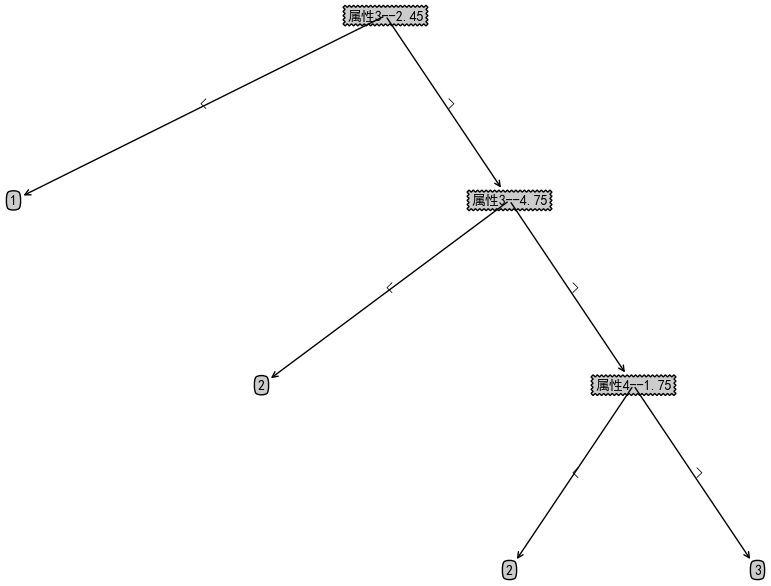

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 2 2 2 2 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3
 3]
0.96


In [69]:
def predict_item(Tree, data):
    first_feature = list(Tree.keys())[0] 
    bestFea, val = first_feature.split('--')
    
    if data[int(bestFea[2])-1] <= float(val):
        subTree = Tree[first_feature]['<'] 
    elif data[int(bestFea[2])-1] > float(val):
        subTree = Tree[first_feature]['>'] 
    
    if isinstance(subTree, dict):
        label_pred = predict_item(subTree, data)
    else:
        label_pred = int(subTree)
   
    return label_pred

def predict(Tree,test_data):
    test_label = []
    for data in test_data:
        label = predict_item(Tree, data)
        test_label.append(label)
    return np.asarray(test_label)

def score(test_data, test_label, Tree):
    label_pre = predict(Tree, test_data)
    return np.sum(label_pre == test_label) / len(test_label)

testdata,testlabel, nameArr = loadData("data/traindata.txt")
testtree = createTree(testdata,testlabel,nameArr,4) 
print(testtree)
# leafNum,treeDepth = getTreeSize(testtree)
# print(leafNum); print(treeDepth)
createPlot(testtree)
test1data,test1label, name1Arr = loadData("data/testdata.txt")
class_label = predict(testtree,test1data)
print(class_label)
print(score(test1data,test1label,testtree))

## 决策树画图函数

In [68]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt 
 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号 #有中文出现的情况，需要u'内容'


decisionNodeStyle = dict(boxstyle = "sawtooth", fc = "0.8")
leafNodeStyle = {"boxstyle": "round4", "fc": "0.8"}
arrowArgs = {"arrowstyle": "<-"}


# 画节点
def plotNode(nodeText, centerPt, parentPt, nodeStyle):
    createPlot.ax1.annotate(nodeText, xy = parentPt, xycoords = "axes fraction", xytext = centerPt
                            , textcoords = "axes fraction", va = "center", ha="center", bbox = nodeStyle, arrowprops = arrowArgs)


# 添加箭头上的标注文字
def plotMidText(centerPt, parentPt, lineText):
    xMid = (centerPt[0] + parentPt[0]) / 2.0
    yMid = (centerPt[1] + parentPt[1]) / 2.0 
    createPlot.ax1.text(xMid, yMid, lineText)
    
    
# 画树
def plotTree(decisionTree, parentPt, parentValue):
    # 计算宽与高
    leafNum, treeDepth = getTreeSize(decisionTree) 
    # 在 1 * 1 的范围内画图，因此分母为 1
    # 每个叶节点之间的偏移量
    plotTree.xOff = plotTree.figSize / (plotTree.totalLeaf - 1)
    # 每一层的高度偏移量
    plotTree.yOff = plotTree.figSize / plotTree.totalDepth
    # 节点名称
    nodeName = list(decisionTree.keys())[0]
    # 根节点的起止点相同，可避免画线；如果是中间节点，则从当前叶节点的位置开始，
    #      然后加上本次子树的宽度的一半，则为决策节点的横向位置
    centerPt = (plotTree.x + (leafNum - 1) * plotTree.xOff / 2.0, plotTree.y)
    # 画出该决策节点
    plotNode(nodeName, centerPt, parentPt, decisionNodeStyle)
    # 标记本节点对应父节点的属性值
    plotMidText(centerPt, parentPt, parentValue)
    # 取本节点的属性值
    treeValue = decisionTree[nodeName]
    # 下一层各节点的高度
    plotTree.y = plotTree.y - plotTree.yOff
    # 绘制下一层
    for val in treeValue.keys():
        # 如果属性值对应的是字典，说明是子树，进行递归调用； 否则则为叶子节点
        if type(treeValue[val]) == dict:
            plotTree(treeValue[val], centerPt, str(val))
        else:
            plotNode(treeValue[val], (plotTree.x, plotTree.y), centerPt, leafNodeStyle)
            plotMidText((plotTree.x, plotTree.y), centerPt, str(val))
            # 移到下一个叶子节点
            plotTree.x = plotTree.x + plotTree.xOff
    # 递归完成后返回上一层
    plotTree.y = plotTree.y + plotTree.yOff
    
    
# 画出决策树
def createPlot(decisionTree):
    if type(decisionTree).__name__=="int":
        print("This is not a tree")
        return 
    fig = plt.figure(1, facecolor = "white")
    fig.clf()
    axprops = {"xticks": [], "yticks": []}
    createPlot.ax1 = plt.subplot(111, frameon = False, **axprops)
    # 定义画图的图形尺寸
    plotTree.figSize = 1.5 
    # 初始化树的总大小
    plotTree.totalLeaf, plotTree.totalDepth = getTreeSize(decisionTree)
    # 叶子节点的初始位置x 和 根节点的初始层高度y
    plotTree.x = 0 
    plotTree.y = plotTree.figSize
    plotTree(decisionTree, (plotTree.figSize / 2.0, plotTree.y), "")
    plt.show()

# 限定深度ID3
testdata,testlabel, nameArr = loadData("data/traindata.txt")
testtree = createTree(testdata,testlabel,nameArr,1) 
print(testtree)
# leafNum,treeDepth = getTreeSize(testtree)
# print(leafNum); print(treeDepth)
createPlot(testtree)

1
This is not a tree
